## EarthCARE ESA MAAP Data Access Example  

@ ESA, 2025
= Licensed under "European Space Agency Community License" 

Author: Saskia Brose (saskia.brose@esa.int)

Date: 18-09-2025

---

This script shows how to query the ESA MAAP catalog, stream/download EarthCARE data, and the plot the cloud water path and cloud top tempetaure

### Prerequisities

In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import pathlib

### Using the STAC API to query the ESA MAAP stac catalog
While the discovery of data (querying the ESA MAAP catalogue) does not require any authentication or authorization, accessing the data requires a token generated with an authorized eoiam account (EO Sign in) to verify the user. This is the same account and credentials you will have used for the OADS system.

Currently this token is valid for 12 h, in the near future this token will be longer-lasting and a refresh option to better support M2M processes. 

In [2]:
catalog_url = 'https://catalog.maap.eo.esa.int/catalogue/'
catalog = Client.open(catalog_url)

The EarthCARE collections have the same name as previously on OADS, but have the extension `_MAAP` to distinguish them from the OADS collections. Currently the latest two baselines are provided and there are 12 collections: 

* EarthCAREL1Validated_MAAP
* EarthCAREL2Validated_MAAP 
* JAXAL2Validated_MAAP
* EarthCAREL1InstChecked_MAAP
* EarthCAREL2InstChecked_MAAP 
* JAXAL2InstChecked_MAAP
* EarthCAREL01L1Products_MAAP
* EarthCAREL2Products_MAAP
* EarthCAREXMETL1DProducts10_MAAP
* JAXAL2Products_MAAP
* EarthCAREOrbitData_MAAP
* EarthCAREAuxiliary_MAAP

In [3]:
# Select one collection
EC_COLLECTION = ['EarthCAREL2Validated_MAAP']

The **second** step is to further narrow down your search: 

**Datetime** represents the temporal coverage of the data. None can be used for both start and end to indicated unbounded queries.  

**bbox** is defined by the bottom left corner (longmin latmin) and the top right corner coordinates (longmax latmax). 

----


**Filter** – allows you to search based on different metadata parameters.  
To understand which queryables exist, you can visit:  
`https://catalog.maap.eo.esa.int/catalogue/collections/<insertcollectionname>/queryables`
Examples include: 
* productType
* frame 
* processingLevel
* instrument
* orbitNumber 



In [4]:
search = catalog.search(
    collections=EC_COLLECTION, 
    filter="productType = 'MSI_COP_2A' and frame = 'E' ", # Filter by product type
    bbox = [0, -20, 10, -10],
    #datetime = ['2025-06-06T00:00:00Z', None] 
    method = 'GET', # This is necessary 
    max_items=5  # Adjust as needed, given the large amount of products it is recommended to set a limit if especially if you display results in pandas dataframe or similiar
)

items = list(search.items())
print(f"Accessing {len(items)} items (limited by max_items).")
print(f"{search.matched()} items found that matched the query.")

Accessing 5 items (limited by max_items).
84 items found that matched the query.


### Results

Understanding Assets in the ESA MAAP STAC Catalog: Each granule (one frame of EarthCARE data per product) includes multiple **assets**, which are different files that serve distinct purposes. These assets can include preview images, scientific data, metadata, and more.

**Types of assets in a granule**:

| **Asset Name**        | **Description**                                                                 | **File Type** | **Purpose / Use**                                 |
|------------------------|---------------------------------------------------------------------------------|---------------|---------------------------------------------------|
| thumbnail / quicklook | Preview images of the granule area                                              | .jpeg       | Quick visual inspection                           |
| enclosure_1         | Main scientific data file (e.g. EarthCARE Level 1B product)                          | .h5         | Use this for streaming or downloading the file(s) of interest.       |
| enclosure_2         | Header file with additional metadata for the data file                          | .HDR        | Provides structural information for .h5 file    |
| product             | Complete zipped product bundle                                                   | .zip        | For full download (not recommended unless necessary)  |
| metadata_ogc_10_157r4, metadata_ogc_17_003r2, metadata_iso_19139 | Metadata files for cataloging and discovery | .xml, .json |              |


**Tips**: 

- **Want a quick look?** Use the quicklook or thumbnail to preview the data.
- **Need to analyze?** Work with the enclosure_1 (the .h5 file)   this is demonstrated in the next cells.
- **Don't need everything?** Avoid the .zip unless you really need to download all files.
- **Curious about metadata?** Open the XML/JSON metadata files for detailed info.



In [5]:
# Access the first item only
item = items[0]

print(f"Item 0 — ID: {item.id if hasattr(item, 'id') else item.get('id')}")

# If item is a pystac.Item
try:
    assets = item.assets
except AttributeError:
    # If item is a dict
    assets = item.get("assets", {})

if assets:
    print("  Available asset keys:")
    for key in assets.keys():
        print("   -", key)
else:
    print("  No assets found for this item.")

Item 0 — ID: ECA_EXAB_MSI_COP_2A_20250507T131854Z_20250507T162714Z_05346E
  Available asset keys:
   - thumbnail
   - enclosure_1
   - product
   - enclosure_2
   - metadata_ogc_10_157r4
   - metadata_ogc_17_003r2
   - metadata_iso_19139
   - quicklook


In [6]:
# Using Pandas dataframes for ease of use. This is not mandatory, but just a nice way to get an overview of the products you found through the search. Please note that pandas dataframes run into issues if we try to pass to many products. Use max_items! :) 
data = search.item_collection_as_dict()

df = pd.json_normalize(data, record_path=['features'])[
    [
        "id",
        "properties.product:type",                
        "properties.updated",                     
        "assets.product.href",
        #"assets.thumbnail.href",
        "assets.quicklook.href",
        "assets.enclosure_1.href",
        "assets.enclosure_2.href",
    ]
]

# Renaming the assets for 
df.rename(columns={
    'properties.product:type': 'product_type',
    'properties.updated': 'last_modified',
    'assets.product.href': 'Zipped Product',
    #'assets.thumbnail.href': 'thumbnail_url',
    'assets.quicklook.href': 'quicklook_url',
    'assets.enclosure_1.href': 'h5_url',
    'assets.enclosure_2.href': 'HDR_url',
}, inplace=True)

df.sort_values(by='id', ascending=True, inplace=True)


In [7]:
df

id product_type  \
0  ECA_EXAB_MSI_COP_2A_20250507T131854Z_20250507T...   MSI_COP_2A   
2  ECA_EXAB_MSI_COP_2A_20250509T144033Z_20250509T...   MSI_COP_2A   
3  ECA_EXAB_MSI_COP_2A_20250617T132215Z_20250617T...   MSI_COP_2A   
1  ECA_EXAB_MSI_COP_2A_20250624T132947Z_20250624T...   MSI_COP_2A   
4  ECA_EXBA_MSI_COP_2A_20250827T134358Z_20250827T...   MSI_COP_2A   

          last_modified                                     Zipped Product  \
0  2025-09-12T11:44:50Z  https://catalog.maap.eo.esa.int/data/zipper/ea...   
2  2025-09-12T11:46:18Z  https://catalog.maap.eo.esa.int/data/zipper/ea...   
3  2025-09-12T12:14:37Z  https://catalog.maap.eo.esa.int/data/zipper/ea...   
1  2025-09-12T12:18:38Z  https://catalog.maap.eo.esa.int/data/zipper/ea...   
4  2025-09-12T12:36:13Z  https://catalog.maap.eo.esa.int/data/zipper/ea...   

                                       quicklook_url  \
0  https://catalog.maap.eo.esa.int/data/earthcare...   
2  https://catalog.maap.eo.esa.int/data/earthcare...   
3  https://catalog.maap.eo.esa.int/data/earthcare...   
1  https://catalog.maap.eo.esa.int/data/earthcare...   
4  https://catalog.maap.eo.esa.int/data/earthcare...   

                                              h5_url  \
0  https://catalog.maap.eo.esa.int/data/earthcare...   
2  https://catalog.maap.eo.esa.int/data/earthcare...   
3  https://catalog.maap.eo.esa.int/data/earthcare...   
1  https://catalog.maap.eo.esa.int/data/earthcare...   
4  https://catalog.maap.eo.esa.int/data/earthcare...   

                                             HDR_url  
0  https://catalog.maap.eo.esa.int/data/earthcare...  
2  https://catalog.maap.eo.esa.int/data/earthcare...  
3  https://catalog.maap.eo.esa.int/data/earthcare...  
1  https://catalog.maap.eo.esa.int/data/earthcare...  
4  https://catalog.maap.eo.esa.int/data/earthcare...

### Quicklook of the data

You don't need to authenticate or authorize to preview the data.  
By referencing the `thumbnail` asset, you're accessing a remote URL where a quicklook image of the product is stored.  
This provides a fast and convenient way to visually inspect the data before downloading or processing it.


In [8]:
# Choose the file you want to view/stream/download 

fileno = 2 # Adjust this as desired 
ql_url = df.loc[fileno, "quicklook_url"]
# Note: thumbnail is a lower resolution version
display(Image(url= ql_url))


### Token
Paste your token below or save it in a token.txt. The latter approach is recommended.

You can generate the token [here](https://portal.maap.eo.esa.int/ini/services/auth/token/index.php). Currently this is only valid for 10 h! 


In [9]:
# Optional 
_TOKEN = ''

In [10]:
# Better practice than pasting your token in the cell above
if pathlib.Path("token_yourname.txt").exists():
  with open("token_yourname.txt","rt") as f:
    token = f.read().strip().replace("\n","")
else:
  token=_TOKEN

## Stream and plot data

In [11]:
# Fetching the url of the desired file
ds_url = df.loc[fileno, "h5_url"]
print(ds_url)


https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/MSI_COP_2A/AB/2025/05/09/ECA_EXAB_MSI_COP_2A_20250509T144033Z_20250509T161638Z_05378E/ECA_EXAB_MSI_COP_2A_20250509T144033Z_20250509T161638Z_05378E/ECA_EXAB_MSI_COP_2A_20250509T144033Z_20250509T161638Z_05378E.h5


In [12]:
io_params = {
    "fsspec_params": {
        "cache_type": "blockcache",
        "block_size": 8 * 1024 * 1024
    },
    "h5py_params": {
        "driver_kwds": {
            "rdcc_nbytes": 8 * 1024 * 1024
        }
    }
}

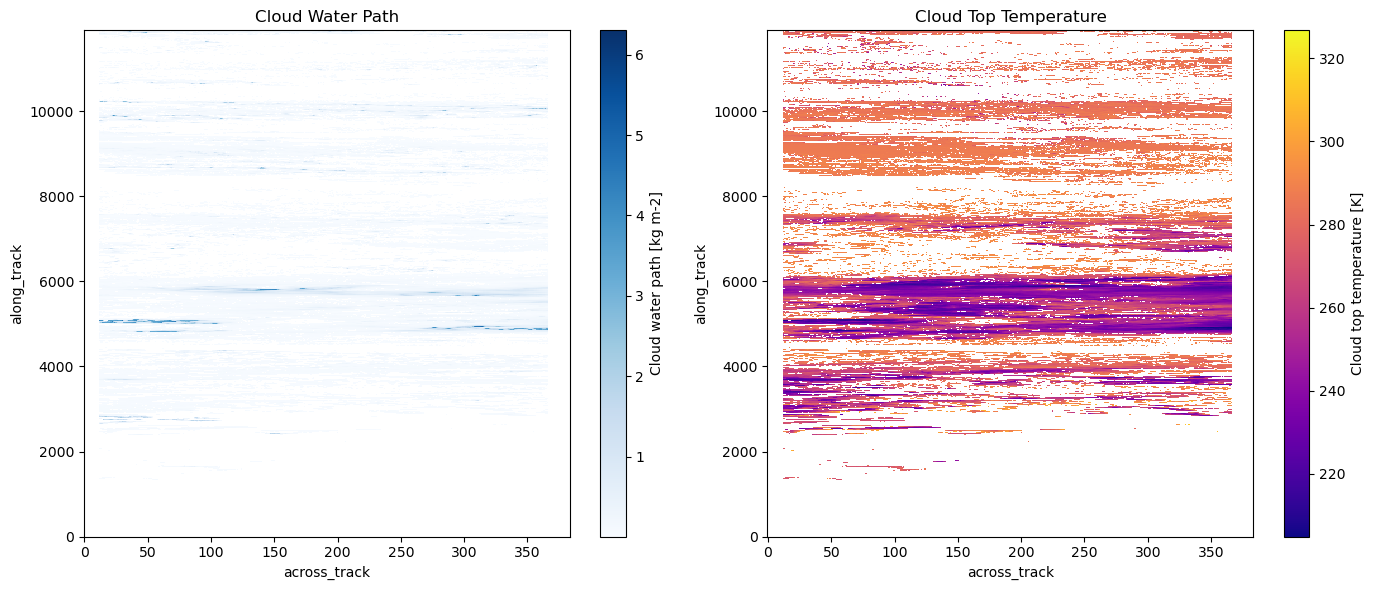

In [13]:
fs = fsspec.filesystem(
    "https", 
    headers={"Authorization": f"Bearer {token}"}, 
    **io_params["fsspec_params"]  )

# Open the file and read it into an xarray Dataset
with fs.open(ds_url, "rb") as f:
    ds = xr.open_dataset(f, 
                         engine="h5netcdf", 
                         **io_params["h5py_params"],  
                         group="ScienceData")

    # Do something with ds! Here we plot two variables as an example.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Cloud Water Path
    ds["cloud_water_path"].plot(ax=axes[0], cmap="Blues")
    axes[0].set_title("Cloud Water Path")

    # Plot Cloud Top Temperature
    ds["cloud_top_temperature"].plot(ax=axes[1], cmap="plasma")
    axes[1].set_title("Cloud Top Temperature")

    plt.tight_layout()
    plt.show()

## Download data 
You can also use your token and the url to download data and not just stream it.

In [14]:
def download_file_with_bearer_token(url, token, disable_bar=False):
  """
  Downloads a file from a given URL using a Bearer token.
  """

  try:
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes
    file_size = int(response.headers.get('content-length', 0))

    chunk_size = 8 * 1024 * 1024 # Byes - 1MiB
    file_path = url.rsplit('/', 1)[-1] 
    print(file_path)
    with open(file_path, "wb") as f, tqdm(
        desc=file_path,
        total=file_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
        disable=disable_bar,
      ) as bar:
      for chunk in response.iter_content(chunk_size=chunk_size):
        read_size=f.write(chunk)
        bar.update(read_size)

    if (disable_bar): 
      print(f"File downloaded successfully to {file_path}")

  except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")

In [15]:
download_file_with_bearer_token(ds_url, token)

ECA_EXAB_MSI_COP_2A_20250509T144033Z_20250509T161638Z_05378E.h5


ECA_EXAB_MSI_COP_2A_20250509T144033Z_20250509T161638Z_05378E.h5: 100%|██████████| 130M/130M [00:03<00:00, 36.7MiB/s] 
